Após a extração dos dados dos fundos de investimento na XP e posterior análise na planilha do excel, eu selecionei os 3 melhores fundos que se encaixaram nos meus filtros (somente renda variável, taxa de adm menor ou igual a 2, rentabilidade nos últimos 36 meses maior ou igual a 30%, rentabilidade nos últimos 24 meses acima de 0% e data de ínicio do fundo anterior a 2019). Com essa base irei tomar decisões de investir ou não nestes fundos. Vou considerar os últimos 3 anos como base, e usarei a biblioteca investpy para buscar os dados históricos dos fundos de investimentos, a yfinance para dados do indice bovespa e dois arquivos csv com o historico do cdi e ipca extraídos do site do banco central.

Imports

In [1]:
import investpy as inv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import math
import yfinance as yf
plt.rcParams['figure.figsize'] = 15,6

Funções

In [2]:
# Função para calcular o retorno acumulado e normalizado
def retorno_acumulado(series):
    retorno_acumulado = (1+series).cumprod()
    return retorno_acumulado

# Função para calcular o retorno percentual
def retorno_percentual(acm1,acm2,acm3):
    return (acm1[-1]-1,acm2[-1]-1,acm3[-1]-1)
    
# Função para calcular a volatilidade com base anual   
def vol_anual(series):
    vol_anual = series.std()*math.sqrt(252)
    return vol_anual

# Função para calcular o índice de sharpe
def sharpe(ri,rf,vol):
    indice=(ri-rf)/vol
    return indice

# Função para buscar o histórico do fundo pelo código no site investing.com
def get_funds_data(symbol):
    dados = inv.funds.search_funds(by='symbol', value= symbol)
    dados = dados.loc[0,'name']
    get_fund = inv.funds.get_fund_historical_data(fund= dados,
                                        country='Brazil',
                                        from_date='01/01/2019',
                                        to_date='31/12/2021')['Close']
    return get_fund

# Função para buscar o histórico do cdi e ipca
def get_indexes(indice, column_rename):
    indice = pd.read_csv('{}.csv'.format(indice),sep=';')
    indice['data'] = pd.to_datetime(indice['Data'], dayfirst=True, errors='coerce')
    indice.drop(['Data'],axis=1, inplace=True)
    indice.rename(columns={indice.columns[0]: column_rename}, inplace=True)
    indice.set_index('data', inplace=True)
    indice.drop(index=indice.index[-1], inplace=True)
    indice = indice[column_rename].str.replace(',','.')
    indice = indice.astype(float)
    indice = indice.squeeze()
    return indice

Buscando dados históricos dos 3 fundos, do ibovespa, do CDI e do IPCA

In [3]:
ip = get_funds_data('0P0000U6PB')
lis = get_funds_data('0P00017QOR')
guepardo = get_funds_data('0P0000U67E')

In [4]:
ibov = yf.download(tickers='^BVSP')[['Adj Close']].reset_index()
ibov = ibov[(ibov['Date'] > '01-01-2019') & (ibov['Date'] <= '31-12-2021')].set_index('Date').squeeze()

[*********************100%***********************]  1 of 1 completed


In [5]:
cdi = get_indexes('cdi','cdi')
ipca = get_indexes('ipca','ipca')

Comparando os retornos diários (quanto mais "tremido" os retornos parecerem nos gráficos, mais volátil é o ativo).

In [6]:
ip_retornos = ip.pct_change()
guepardo_retornos = guepardo.pct_change()
lis_retornos = lis.pct_change()
ibov_retornos = ibov.pct_change()

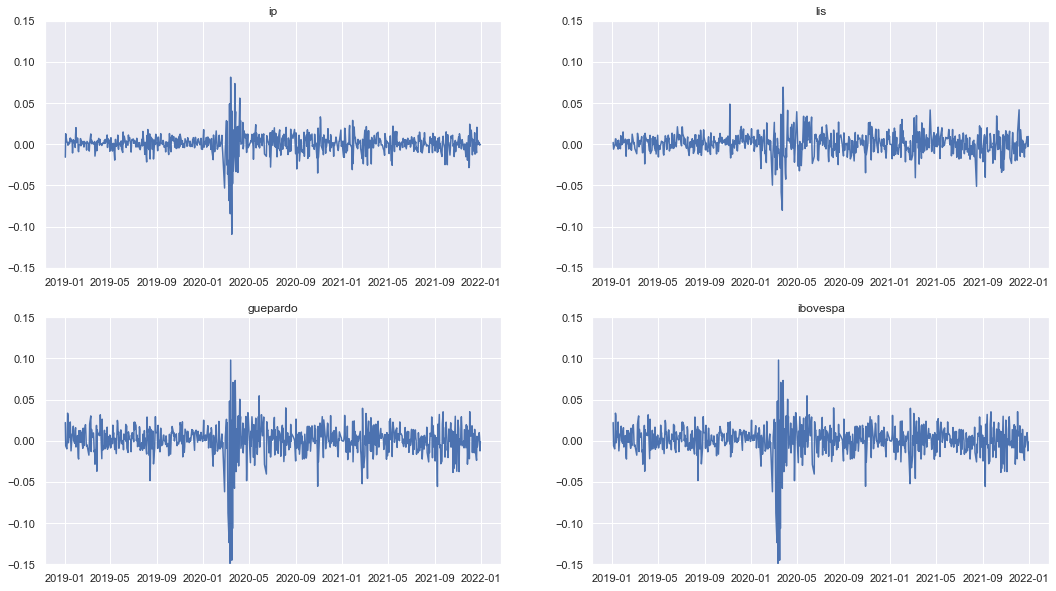

In [7]:
plt.figure(figsize=(18,10))
plt.subplot(2, 2, 1)
plt.plot(ip_retornos)
plt.title('ip')
plt.ylim(-0.15, 0.15) 

plt.subplot(2, 2, 2)
plt.plot(lis_retornos)
plt.title('lis')
plt.ylim(-0.15, 0.15) 

plt.subplot(2, 2, 3)
plt.plot(guepardo_retornos)
plt.title('guepardo')
plt.ylim(-0.15, 0.15)

plt.subplot(2, 2, 4)
plt.plot(guepardo_retornos)
plt.title('ibovespa')
plt.ylim(-0.15, 0.15) 

plt.show()

Comparando a Volatilidade

In [8]:
vol_anual_ip = vol_anual(ip_retornos)
vol_anual_lis = vol_anual(lis_retornos)
vol_anual_guepardo = vol_anual(guepardo_retornos)
vol_anual_ibov = vol_anual(ibov_retornos)

print('Volatilidade Anualizada do Fundo IP Participações: {0:.2f}%'.format(vol_anual_ip*100))
print('Volatilidade Anualizada do Fundo Lis Value: {0:.2f}%'.format(vol_anual_lis*100))
print('Volatilidade Anualizada do Fundo Guepardo Institucional: {0:.2f}%'.format(vol_anual_guepardo*100))
print('Volatilidade Anualizada do Ibovespa: {0:.2f}%'.format(vol_anual_ibov*100))

Volatilidade Anualizada do Fundo IP Participações: 20.19%
Volatilidade Anualizada do Fundo Lis Value: 21.20%
Volatilidade Anualizada do Fundo Guepardo Institucional: 31.11%
Volatilidade Anualizada do Ibovespa: 30.27%


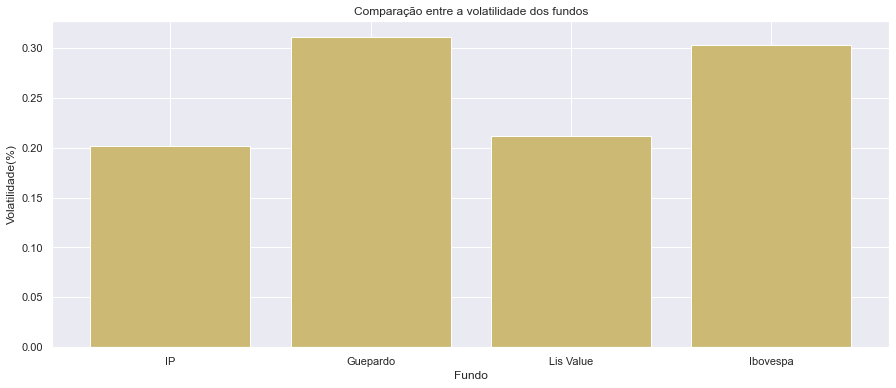

In [9]:
lista = [('IP',vol_anual_ip),('Guepardo',vol_anual_guepardo),('Lis Value',vol_anual_lis),('Ibovespa',vol_anual_ibov)]
labels, values = zip(*lista)

plt.bar(labels, values, color='y')
plt.xlabel('Fundo')
plt.ylabel('Volatilidade(%)') 
plt.title('Comparação entre a volatilidade dos fundos')
plt.show()

Comparando o retorno acumulado

In [10]:
ip_acm = retorno_acumulado(ip_retornos)
guepardo_acm = retorno_acumulado(guepardo_retornos)
lis_acm = retorno_acumulado(lis_retornos)
ibov_acm = retorno_acumulado(ibov_retornos)

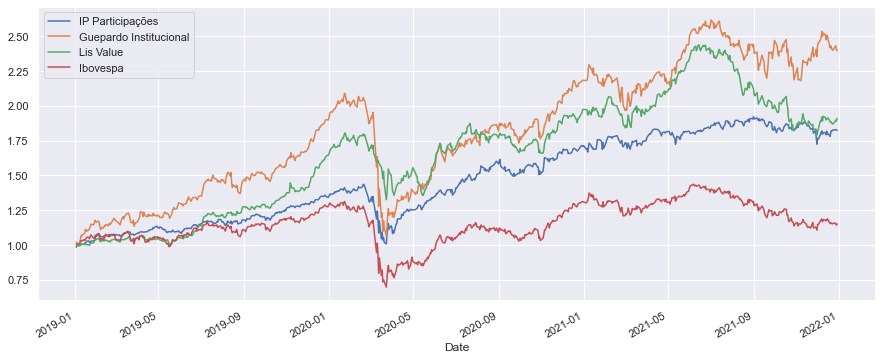

In [11]:
ip_acm.plot(label='IP Participações')
guepardo_acm.plot(label='Guepardo Institucional')
lis_acm.plot(label='Lis Value')
ibov_acm.plot(label='Ibovespa')

plt.legend()
plt.show()

Todos os fundos performaram bem melhor que o ibovespa nos últimos 3 anos. O Guepardo Institucional teve um desempenho melhor porém com mais volatilidade.

Trazendo os dados do IPCA e do CDI para calcular o indice de sharpe (é preciso da taxa livre de risco do período). Quando maior o índice, melhor.

In [12]:
ipca_acm = (1+ ipca / 100).cumprod()
cdi_acm = (1+ cdi / 100).cumprod()

In [13]:
ip_retorno_perc, lis_retorno_perc, guepardo_retorno_perc = retorno_percentual(ip_acm,lis_acm,guepardo_acm)
risk_free = cdi_acm[-1]-1 

sharpe_ip = sharpe(ip_retorno_perc,risk_free,vol_anual_ip)
sharpe_lis = sharpe(lis_retorno_perc,risk_free,vol_anual_lis)
sharpe_guepardo = sharpe(guepardo_retorno_perc,risk_free,vol_anual_guepardo)

print('Indice de Sharpe do Fundo IP Participações nos últimos 36 meses: {0:.2f}' .format(sharpe_ip))
print('Indice de Sharpe do Fundo Lis Value nos últimos 36 meses: {0:.2f}' .format(sharpe_lis))
print('Indice de Sharpe do Fundo Guepardo Institucional nos últimos 36 meses: {0:.2f}' .format(sharpe_guepardo))

Indice de Sharpe do Fundo IP Participações nos últimos 36 meses: 3.41
Indice de Sharpe do Fundo Lis Value nos últimos 36 meses: 3.65
Indice de Sharpe do Fundo Guepardo Institucional nos últimos 36 meses: 4.05


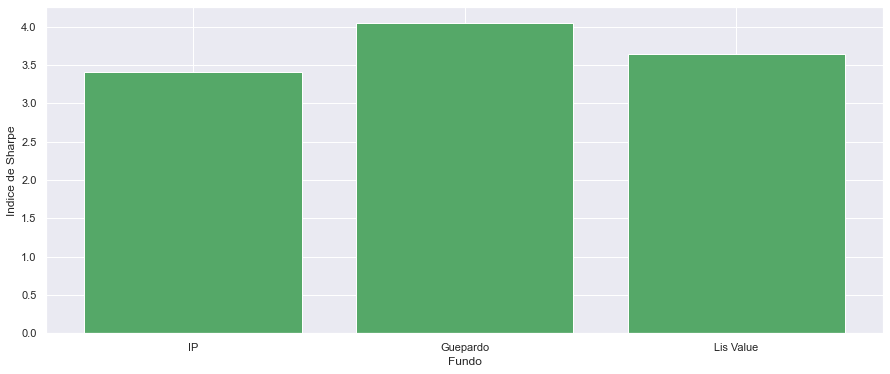

In [14]:
top = [('IP',sharpe_ip),('Guepardo',sharpe_guepardo),('Lis Value',sharpe_lis)]
labels, values = zip(*top)

plt.bar(labels, values,color='g')
plt.xlabel('Fundo')
plt.ylabel('Indice de Sharpe') 
plt.show()

Comparação entre o CDI e o IPCA

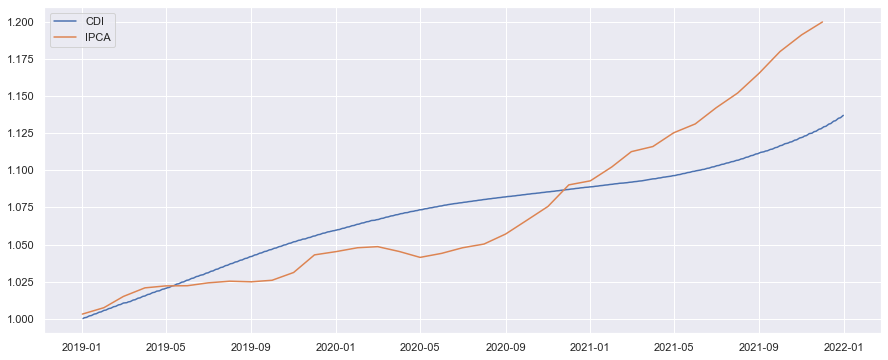

In [15]:
plt.plot(cdi_acm,label='CDI')
plt.plot(ipca_acm,label='IPCA')

plt.legend()
plt.show()

Comparação do retorno entre todos os investimentos

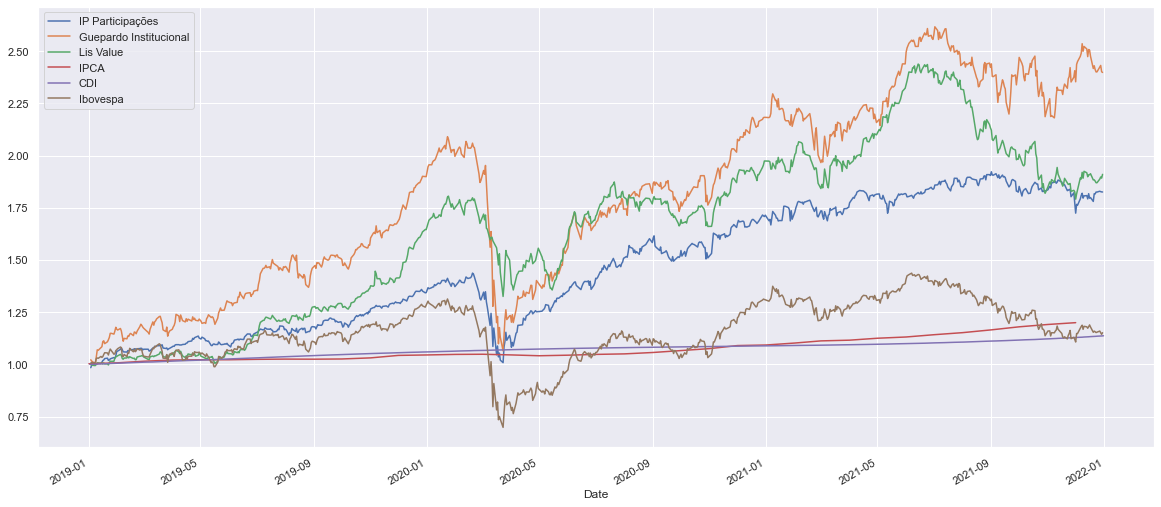

In [17]:
plt.subplots(figsize=(20,9))
ip_acm.plot(label='IP Participações')
guepardo_acm.plot(label='Guepardo Institucional')
lis_acm.plot(label='Lis Value')
ipca_acm.plot(label='IPCA')
cdi_acm.plot(label='CDI')
ibov_acm.plot(label='Ibovespa')

plt.legend(loc='upper left')
plt.show()